# Проект№2
## Дедектирование медицинских масок
Выполнил: Плюснин О.Л.

In [60]:
%pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 102 kB 3.5 MB/s            
     |████████████████████████████████| 47.8 MB 37 kB/s              
     |████████████████████████████████| 14.0 MB 53.0 MB/s            
     |████████████████████████████████| 3.3 MB 57.0 MB/s            
     |████████████████████████████████| 6.9 MB 63.2 MB/s            
     |████████████████████████████████| 180 kB 83.2 MB/s            
     |████████████████████████████████| 16.8 MB 72.8 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use 

In [2]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 60.5 MB 45 kB/s             
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


# Import libraries

# Импорт библиотек

In [41]:
# To download and analyze data
# Для загрузки и анализа данных
import os
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
import shutil

#To work with images and build a model
# Для работы с изображениями и построения модели
import torch
import torchvision
from PIL import Image, ImageDraw
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image as Img
import torchvision
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# To build a model
# Для построения модели
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# for data augmentation
# для аугментации данных
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)

In [8]:
# Data extraction function from annotation files
# Функция извлечения данных из файлов аннотации
def xml_to_csv(path = 'annotations/': str) -> pd.DataFrame:
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[2].text),
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name) # saving the data in a Dataframe сохраняем данные в Датафрейм
    return xml_df

extract the data from the annotation files<br>
the data is stored in xml format<br>
save them in csv format

извлечем данные из файлов аннотаций<br>
данные хранятся в формате xml<br>
сохраним их в формате csv

In [9]:
xml_df = xml_to_csv()
xml_df.to_csv('data.csv', index=None)

100%|██████████| 853/853 [00:00<00:00, 1629.35it/s]


In [199]:
#xml_df = pd.read_csv('data.csv')

In [10]:
xml_df

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,maksssksksss1.png,3,400,156,with_mask,321,34,354,69
1,maksssksksss1.png,3,400,156,with_mask,224,38,261,73
2,maksssksksss1.png,3,400,156,with_mask,299,58,315,81
3,maksssksksss1.png,3,400,156,with_mask,143,74,174,115
4,maksssksksss1.png,3,400,156,with_mask,74,69,95,99
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss850.png,3,400,200,with_mask,323,47,351,78
4068,maksssksksss849.png,3,400,236,with_mask,48,52,67,70
4069,maksssksksss849.png,3,400,236,with_mask,95,20,109,36
4070,maksssksksss849.png,3,400,236,with_mask,213,29,231,50


In [11]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 4072
Количество изображений в датафрэйме 853


In [55]:
xml_df['class'].value_counts()

1    3232
2     717
0     123
Name: class, dtype: int64

## Data processing

## Обработка данных 

Let's encode the classes of objects.

Закодируем классы обьектов.

In [200]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [176]:
xml_df

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,maksssksksss1.png,3,400,156,1,321,34,354,69
1,maksssksksss1.png,3,400,156,1,224,38,261,73
2,maksssksksss1.png,3,400,156,1,299,58,315,81
3,maksssksksss1.png,3,400,156,1,143,74,174,115
4,maksssksksss1.png,3,400,156,1,74,69,95,99
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss850.png,3,400,200,1,323,47,351,78
4068,maksssksksss849.png,3,400,236,1,48,52,67,70
4069,maksssksksss849.png,3,400,236,1,95,20,109,36
4070,maksssksksss849.png,3,400,236,1,213,29,231,50


Some boundboxes go beyond the image, they need to be brought to normal

Некоторые баундбоксы выходят за пределы изображения, их надо привести к нормальным

In [204]:
xml_df[xml_df.xmax==xml_df.width]

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
69,maksssksksss5.png,3,400,266,2,364,30,400,66
309,maksssksksss71.png,3,400,225,1,375,50,400,116
354,maksssksksss74.png,3,400,301,1,391,129,400,149
419,maksssksksss94.png,3,400,226,1,374,66,400,98
462,maksssksksss93.png,3,400,267,1,388,72,400,92
478,maksssksksss103.png,3,400,300,1,368,112,400,151
480,maksssksksss100.png,3,400,226,1,387,54,400,75
558,maksssksksss110.png,3,400,267,2,381,14,400,34
587,maksssksksss121.png,3,400,300,2,387,82,400,107
599,maksssksksss130.png,3,332,400,2,304,95,332,141


In [202]:
for i in range(len(xml_df)):
    if xml_df.iloc[i, 7] > xml_df.iloc[i, 2]:
        xml_df.iloc[i, 7] = xml_df.iloc[i, 2]

Let's save the encoding of the classes in the mapping variable and class_id_to_name_mapping.

Сохраним кодировку классов в переменной mapping и class_id_to_name_mapping.

In [205]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [206]:
mapping

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [207]:
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))

In [208]:
class_id_to_name_mapping

{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

Now we need to bring our data to the format **YOLOv5**.<br>
The annotation of each object should contain the following information:<br>
`Class X Y Width Height`<br>
To do this, use the auxiliary function `convert_to_yolov5'.

Теперь нам нужно привести наши данные к формату **YOLOv5**.<br>
Аннотация каждого объекта должна сожержать следующую информацию:<br>
`Class X Y Width Height`<br>
Для этого воспользуемся вспомогательной функцией `convert_to_yolov5'.

In [31]:
# The function of converting data to Yolo format
# Функция приведения данных в формат Yolo
def convert_to_yolov5(df):

    df_array = np.array(df)

    # For each object
    # Для каждого объекта
        for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        img_name = point[0]

        class_id = point[4]
        
      
        # Convert bbox coordinates
        # Преобразуем координаты bbox
        X = point[5] + ((point[7] - point[5]) / 2 )
        Y = point[6] + ((point[8] - point[6]) / 2 )
        Width    = (point[7] - point[5])
        Height   = (point[8] - point[6])
              
        # Нормализуем координаты
        # Normalize the coordinates
        image_c, image_w, image_h = point[1], point[2], point[3] 
        X /= image_w 
        Y /= image_h 
        Width    /= image_w 
        Height   /= image_h 
              
        # Запишем информацию о bbox в файл
        # # Let's write the information about box to a file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))
              
        # Дадим имя файлам, которые хотим сохранить
        # Give a name to the files we want to save
        save_file_name = "text/image" + str(i+1) + ".txt"
        
        # Сохраним аннотации на диск
        # Save annotations to disk
        print("\n".join(print_buffer), file= open(save_file_name, "w"))
        
        # переименуем файлы с картинками согласно файлов аннотации
        # rename the image files according to the annotation files
        image = cv2.imread('images/' + img_name)
        cv2.imwrite('newimages/image' +  str(i+1) + '.png', image)

In [32]:
# We will get annotations in a new format
# Получим аннотации в новом формате
convert_to_yolov5(xml_df)

Let's check our file conversions

Проверим наши преобразования файлов

In [35]:
len(glob.glob('newimages/' + '*.png')) == len(glob.glob('text/' + '*.txt'))

True

In [36]:
len(glob.glob('newimages/' + '*.png'))

4072

In [37]:
# Bounding box rendering function in pictures
# Функция отрисовки bounding box на картинках
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill="#000")
    
    
    plt.imshow(np.array(image))
    plt.show()

In [43]:
# Let's choose random annotations
# Выберем рандомные аннотации 
annotation_random= !ls text/*txt | shuf -n 4

In [44]:
annotation_random

['text/image3552.txt',
 'text/image3649.txt',
 'text/image3039.txt',
 'text/image357.txt']

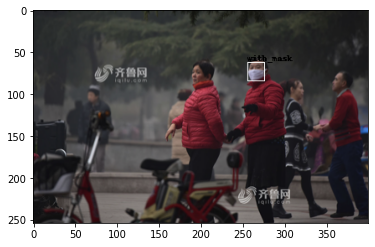

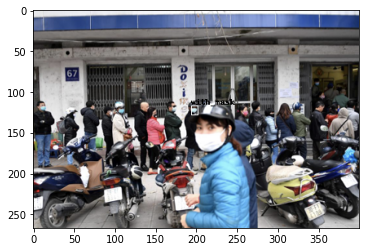

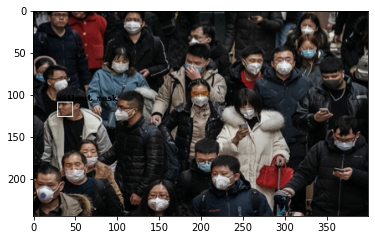

[[1.    0.666 0.291 0.052 0.087]]
[[1.    0.495 0.459 0.02  0.041]]
[[2.    0.096 0.48  0.043 0.069]]
[[2.    0.545 0.352 0.015 0.02 ]]


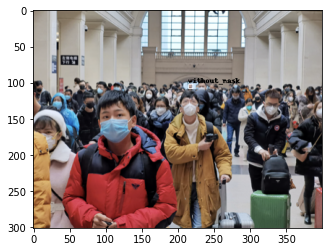

In [45]:
# Draw random annotations
# Отрисуем рандомные аннотации
for annotation_file in annotation_random:
    with open(annotation_file, "r") as file:
        annotation_list = file.read().split("\n")[:-1]
        annotation_list = [x.split(" ") for x in annotation_list]
        annotation_list = [[float(y) for y in x ] for x in annotation_list]
        
        # Get the corresponding image file
        # Получим соответствующий файл изображения
        image_file = annotation_file.replace("txt", "png")
        image_file = image_file.replace("text", "newimages")
        assert os.path.exists(image_file)
        
        # Load the image
        # загрузим изображение
        image = Image.open(image_file)
        
        # Plot the Bounding Box
        # Отрисуем Bounding Box
        plot_bounding_box(image, annotation_list)

We will split the data into training and validation data and move them to the folders necessary for the model

Разобьем данные на тренировочные и валидационные и переместим их в нужные для модели папки

In [48]:
train = int(len(glob.glob('newimages/' + '*.png'))*0.8)

Move the files to folders according to the YOLO specification

Переместим файлы в папки в соответствии со спецификацией YOLO

In [52]:
count = 0
for filename in glob.glob('newimages/' + '*.png'):
    if count < train:
        shutil.copy((filename),
                     os.path.join('dataset/train/images'))
        shutil.copy( os.path.join(filename.replace("png", "txt").replace('newimages', 'text')),
                     os.path.join('dataset/train/labels'))
    
    else:
        shutil.copy( (filename),
                     os.path.join('dataset/valid/images'))
        shutil.copy( os.path.join(filename.replace("png", "txt").replace('newimages', 'text')),
                     os.path.join('dataset/valid/labels'))
    count += 1

## Setup

Clone repo, install dependencies and check PyTorch and GPU.

## Установка

Клонируем репозиторий, установим зависимости

In [53]:
!git clone https://github.com/ultralytics/yolov5  # clone клонирование
%pip install -qr yolov5/requirements.txt  # install установка

Cloning into 'yolov5'...
remote: Enumerating objects: 12732, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12732 (delta 3), reused 0 (delta 0), pack-reused 12722
Receiving objects: 100% (12732/12732), 11.68 MiB | 23.09 MiB/s, done.
Resolving deltas: 100% (8880/8880), done.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


## Training

## Обучение

In [54]:
#!c1.32
!python3 yolov5/train.py --img 640 --batch 16 --epochs 100 --data config.yaml --weights yolov5s.pt --cache --device 0

     74/99     5.26G   0.01999   0.01781 0.0009016        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        815        815      0.297      0.379      0.293      0.212

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     75/99     5.26G    0.0197   0.01785  0.000997        14       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        815        815      0.454      0.258      0.299      0.217

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     76/99     5.26G   0.01981   0.01782 0.0007717        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        815        815      0.253      0.401      0.283       0.21

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     77/99     5.26G   0.01966   0.01

In [56]:
#!g1.1
!python3 yolov5/train.py --img 640 --batch 16 --epochs 100 --data config.yaml --weights yolov5/runs/train/exp/weights/best.pt --cache --evolve --device 0 

     74/99     3.59G   0.01633   0.01917  0.000587        15       640: 100%|███

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     75/99     3.59G   0.01599   0.01916 0.0006063        14       640: 100%|███

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     76/99     3.59G   0.01602   0.01918  0.000517        16       640: 100%|███

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     77/99     3.59G   0.01593   0.01928 0.0005531        17       640: 100%|███

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     78/99     3.59G     0.016    0.0187 0.0005531        17       640: 100%|███

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     79/99     3.59G   0.01566   0.01888 0.0005447        17       640: 100%|███

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     80/99     3.59G   0.01568   0.01919 0.0006249        17       640: 100%|███



Exception: Process exited with code -1

## Validation

## Валидация

In [58]:
#!g1.1
!python3 yolov5/val.py --weights yolov5/runs/train/exp/weights/best.pt --data config.yaml --img 640 --iou 0.65 --half --device 0

val: data=config.yaml, weights=['yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v6.1-121-g1993efd torch 1.9.1+cu111 CUDA:0 (Tesla V100-SXM2-32GB, 32510MiB)

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/home/jupyter/work/resources/yolov5/../dataset/valid/labels.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        815        815      0.318      0.353      0.329      0.242
mask_weared_incorrect        815         28      0.478      0.425      0.454       0.34
           with_mask        815        664      0.242      0.352      0.286       0.21
        without_mask        815        123    

## Выводы:
Модель обучилась плохо, можно сказать не обучилась совсем. Возможно это связано с небольшим набором данных и малым временем обучения, а также плохой способностью Yolo обучаться на большом количестве мелких объектов на одном изображении.

### FasterRNNC

In [135]:
#!g1.1
# функция для аугментации данных
def get_transforms(phase):
            list_transforms = []
            if phase == 'train':
                  list_transforms.extend([
                                          Flip(p=0.5)
                                        ])
            list_transforms.extend(
                [
                 ToTensorV2(),
                ])
            list_trfms = Compose(list_transforms,
                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
            return list_trfms

In [136]:
#!g1.1
class VOC_2010(Dataset):
    def __init__(self, df, image_dir, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])
        
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(lambda x: torch.tensor(x, dtype=torch.float32), 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image.float(), target, image_id

In [209]:
#!g1.1
# раздеоим данные на обучающие и тестовые
image_ids = xml_df['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'# изображение {len(image_ids)}')
print(f'# train изображений {len(train_ids)}')
print(f'# val изображений {len(val_ids)}')
train_df = xml_df[xml_df['filename'].isin(train_ids)]
val_df = xml_df[xml_df['filename'].isin(val_ids)]

# изображение 853
# train изображений 682
# val изображений 171


In [210]:
#!g1.1
train_dir = 'images/'

train_data = VOC_2010(train_df, train_dir, phase='train')
val_data = VOC_2010(val_df, train_dir, phase='validation')

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(val_data)}')

Размер обучающей выборки 682
Размер валидационной выборки 171


In [211]:
#!g1.1
batch = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

Let's draw one batch of data

Отрисуем один батч данных

In [166]:
#!g1.1
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes'].numpy()
    for i in bbox:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

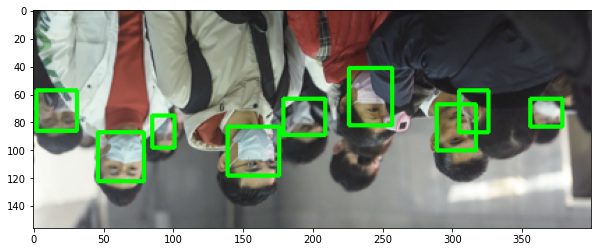

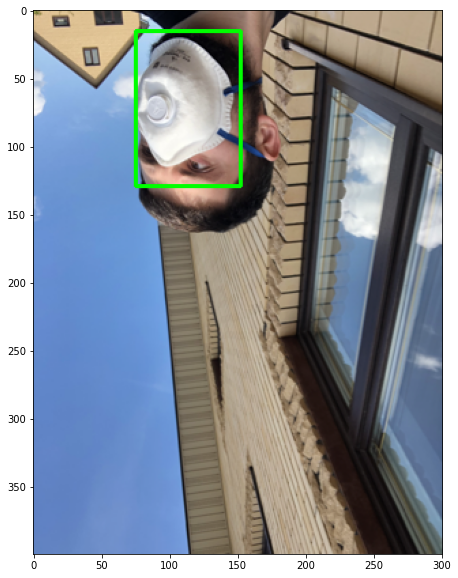

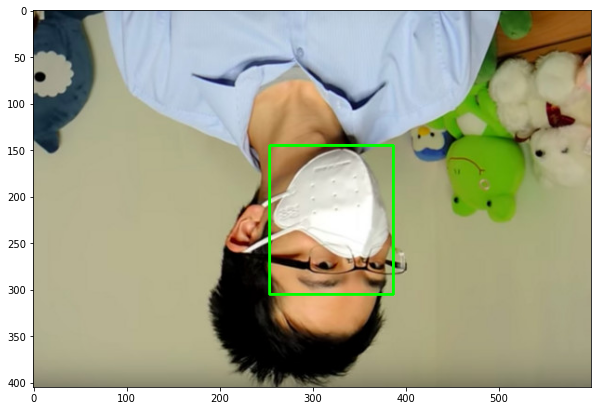

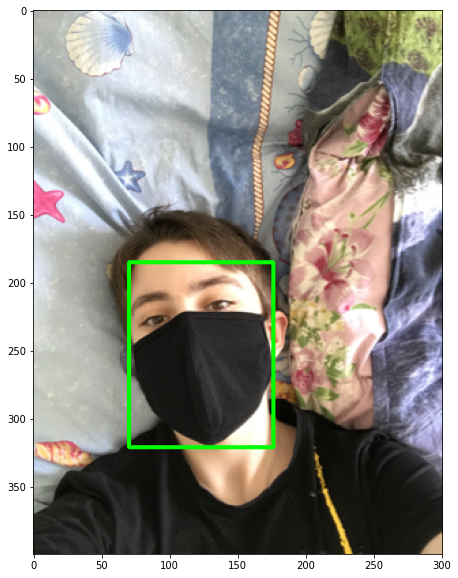

In [212]:
#!g1.1
batch = next(iter(train_data_loader))
batch1 = tuple(zip(batch[0], batch[1]))
for i in range(len(batch[0])):
    plot_img(batch1, i)

In [213]:
#!g1.1
device = torch.device('cuda')

We get a pre-trained model

Получим предобученную модель

In [214]:
#!g1.1
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /tmp/xdg_cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [215]:
#!g1.1
num_classes = len(np.unique(xml_df['class'])) 
print(f'Число классов: {num_classes}')

# Получим число входных признаков для классификатора
# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Заменим классификатор на новый
# Replace the classifier with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Число классов: 3


## Training

## Обучение

In [216]:
#!g1.1
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005)

In [217]:
#!g1.1
%%time
num_epochs = 100
train_loss_min = 0.9
total_train_loss = []


for epoch in tqdm(range(num_epochs)):
    print(f'Epoch :{epoch + 1}')
    
    train_loss = []
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    epoch_train_loss = np.mean(train_loss)
    print('epoch_train_loss', epoch_train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')

Epoch :1
epoch_train_loss 0.5204208405220021
Epoch train loss is 0.5204208405220021
Epoch :2
epoch_train_loss 0.3818422276853469
Epoch train loss is 0.3818422276853469
Epoch :3
epoch_train_loss 0.3419866529211663
Epoch train loss is 0.3419866529211663
Epoch :4
epoch_train_loss 0.3080542274473006
Epoch train loss is 0.3080542274473006
Epoch :5
epoch_train_loss 0.29136172372695296
Epoch train loss is 0.29136172372695296
Epoch :6
epoch_train_loss 0.2798555454576922
Epoch train loss is 0.2798555454576922
Epoch :7
epoch_train_loss 0.268333608142988
Epoch train loss is 0.268333608142988
Epoch :8
epoch_train_loss 0.25720131238214455
Epoch train loss is 0.25720131238214455
Epoch :9
epoch_train_loss 0.24902562849354326
Epoch train loss is 0.24902562849354326
Epoch :10
epoch_train_loss 0.24532429442593925
Epoch train loss is 0.24532429442593925
Epoch :11
epoch_train_loss 0.23398697862063933
Epoch train loss is 0.23398697862063933
Epoch :12
epoch_train_loss 0.22995360764233688
Epoch train loss is

100%|██████████| 100/100 [2:12:56<00:00, 79.76s/it]


In [227]:
#!g1.1
# saving the model
# сохраняем модель
torch.save(model, 'fasterrcnn')

## Validation

## Валидация

In [218]:
#!g1.1
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

We visualize it on a validation sample

Визуализируем на валидационной выборке

In [225]:
#!g1.1
data = next(iter(valid_data_loader))
images = data[0]
targets = data[1]
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
preds = model(images, targets)

In [297]:
#!g1.1
data[2]

('maksssksksss685', 'maksssksksss687', 'maksssksksss688', 'maksssksksss689')

In [303]:
#!g1.1
torch.tensor((np.array(xml_df[xml_df.filename==data[2][0]+'.png'].iloc[:, 5:])))

tensor([[ 12,  37,  54,  79],
        [147,  47, 197, 103],
        [292,  55, 315,  80],
        [381,  56, 400,  77]])

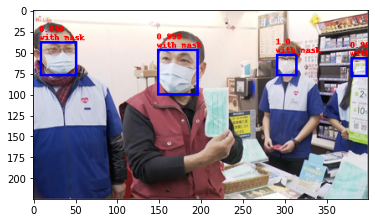

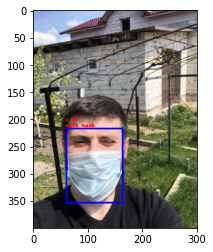

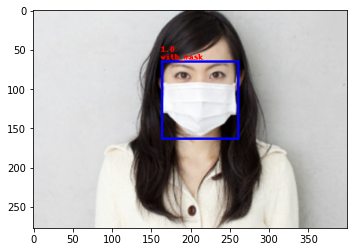

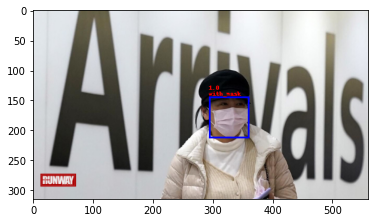

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: plotted_image
  warnings.warn(message)


In [296]:
#!g1.1
for i in range(len(images)):
    image = Image.fromarray((images[i] * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    plotted_image = ImageDraw.Draw(image)
    for j in range(len(preds[i]['boxes'])):
        plotted_image.rectangle(((preds[i]['boxes'][j][0], preds[i]['boxes'][j][1]), (preds[i]['boxes'][j][2], preds[i]['boxes'][j][3])), outline='blue', width=3)
        plotted_image.text((preds[i]['boxes'][j][0], preds[i]['boxes'][j][1] - 10), class_id_to_name_mapping[(int(preds[i]['labels'][j].cpu().numpy()))], fill="red", width=10)
        plotted_image.text((preds[i]['boxes'][j][0], preds[i]['boxes'][j][1] - 20), str(round(preds[i]['scores'][j].item(), 3)), fill="red", width=10)
    plt.imshow(np.array(image))
    plt.show() 

In [226]:
#!g1.1
preds

[{'boxes': tensor([[290.9263,  52.1456, 315.9431,  78.4225],
          [148.1005,  46.6994, 197.3119, 101.5265],
          [  8.0323,  37.9836,  52.5658,  78.4470],
          [379.1644,  56.1753, 399.6413,  79.2790]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9998, 0.9994, 0.9986, 0.9949], device='cuda:0',
         grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 60.6202, 216.9810, 165.5687, 354.3756]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9996], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[163.1532,  64.7610, 262.2892, 164.1991]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9999], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[294.2611, 144.6377, 361.6119, 213.3874]], device='cuda:0',
         grad_fn=<StackBackward>),
 

In [311]:
#!g1.1
targets

[{'boxes': tensor([[ 12.,  37.,  54.,  79.],
          [147.,  47., 197., 103.],
          [292.,  55., 315.,  80.],
          [381.,  56., 400.,  77.]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'image_id': tensor(0, device='cuda:0'),
  'area': tensor([1764., 2800.,  575.,  399.], device='cuda:0')},
 {'boxes': tensor([[ 57., 211., 168., 353.]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'image_id': tensor(1, device='cuda:0'),
  'area': tensor([15762.], device='cuda:0')},
 {'boxes': tensor([[166.,  67., 260., 160.]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'image_id': tensor(2, device='cuda:0'),
  'area': tensor([8742.], device='cuda:0')},
 {'boxes': tensor([[293., 153., 361., 212.]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'image_id': tensor(3, device='cuda:0'),
  'area': tensor([4012.], device='cuda:0')}]

In [399]:
#!g1.1
# IoU calculation functions
# функции расчета IoU
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 
def bbox_iou(box1, box2):
#     intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
#     intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    
    intersect = intersect_w * intersect_h

#     w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
#     w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

Counting Precision and IoU metrics

Считаем метрики Precision и IoU

In [408]:
#!g1.1
val_loss = []
iou_max_list = []
tp, fp, fn = 0, 0, 0

for images, targets, image_ids in valid_data_loader:
    
    optimizer.zero_grad()
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    with torch.no_grad():
        preds = model(images, targets)
    
    for i in range(len(preds)):
        num_preds = len(preds[i]['boxes'])
        num_targs = len(targets[i]['boxes'])
        
        # If there are fewer predicted labels than in the photo
        # Если предсказаных меток меньше чем на фото
        if num_preds < num_targs:
            num1 = num_preds
            num2 = num_targs
            fn+=num2-num1
            ind = 1
        
        # If the predicted labels are greater or equal than in the photo
        # Если предсказаных меток больше или равно чем на фото
        else:
            num2 = num_preds
            num1 = num_targs
            fp+=num2-num1
            ind = 2
       
        # Search for predicted labels and labels in the photo
        # Перебор предсказанных меток и меток на фото    
        for j in range(num1):
            
            iou_list = []
            
            if ind == 1:
                box1, box2 = preds[i]['boxes'], targets[i]['boxes']
            else:
                box2, box1 = preds[i]['boxes'], targets[i]['boxes']
                
            for z in range(num2):
                iou = bbox_iou(box1[j], box2[z])
                iou_list.append(iou)
            
            # we take the best out of the sorted options
            # из перебранных вариантов берем наилучшее
            iou_max = max(iou_list)
            
            # We count TP, FP, FN by the IoU threshold
            # Считаем TP, FP, FN по порогу IoU
            if iou_max > 0.6:
                if ind == 1:
                    # tags match, correct prediction
                    # метки совпадают, верное предсказание
                    if preds[i]['labels'][j] == targets[i]['labels'][iou_list.index(iou_max)]:
                        tp+=1
                    # tags don't match, false prediction
                    # метки не совпадают, ложное предсказание
                    else:
                        fn+=1
                else:
                    if targets[i]['labels'][j] == preds[i]['labels'][iou_list.index(iou_max)]:
                        tp+=1
                    else:
                        fn+=1
            else:
                # the labels match, but the threshold is lower than the set one
                # метки совападают, но порог ниже установленного
                if targets[i]['labels'][j] == preds[i]['labels'][iou_list.index(iou_max)]:
                    fp+=1
                # tags don't match, false prediction
                # метки не совпадают, ложное предсказание
                else:
                    fn+=1
            iou_max_list.append(iou_max)

In [409]:
#!g1.1
print(tp, fp, fn)

643 198 72


We consider precision

Считаем precision

In [418]:
#!g1.1
p = tp/(tp+fp)

In [419]:
#!g1.1
p

0.7645659928656362

We consider IoU

Считаем IoU

In [410]:
#!g1.1
len(iou_max_list)

739

In [420]:
#!g1.1
res_sum = 0
for i in iou_max_list:
    res = i.item()
    res_sum += res

In [422]:
#!g1.1
res_sum/len(iou_max_list)

0.7758071602893053

## Выводы:
Модель обучилась достаточно хорошо, но порог IoU был взят довольно низкий. Учитывая ограниченность набора данных, данный результат можно признать удовлетворительным.


# Общие выводы по проекту:
Было обучено две модели с разной архитектурой.<br> 
Первая модель **Yolo** наиболее популярная, более быстрая в работе, но требует большего количество эпох для обучения, плохо распознает мелкие объекты, если их много. Мне не удалось обучить ее, т.к. объем данных весьма ограничен.<br>
Вторая модель **FasterRCNN** не такая быстрая, но надежнее в работе. Ее удалось обучить до приемлемого уровня.<br>
Обе модели были предобучены.

